In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [3]:
import h5py

filename = 'lognormal_pixelated_nside_64_galaxies_radialsel_step_0pt5'

nside = 64

#biased 0.05, 0.01, 0.005 [0.001 or better unbiased]
with h5py.File(filename + '.h5', 'r') as f:
    zgals = jnp.asarray(f['zgals'])
    dzgals = 0.0001*(1+zgals)
    wgals = jnp.ones(zgals.shape)
    ngals = jnp.asarray(f['ngals'])
    
filename = 'lognormal_pixelated_nside_64_agns_radialsel_step_0pt5'

with h5py.File(filename + '.h5', 'r') as f:
    zagns = jnp.asarray(f['zgals'])
    dzagns = 0.0001*(1+zagns)
    wagns = jnp.ones(zagns.shape)
    nagns = jnp.asarray(f['ngals'])

print(ngals.sum(),nagns.sum())

960000 96245


In [4]:
from jaxinterp2d import interp2d, CartesianGrid

zMax_1 = 0.5
zMax_2 = 5

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

zgrid_1 = np.expm1(np.linspace(np.log(1), np.log(zMax_1+1), 5000))
zgrid_2 = np.expm1(np.linspace(np.log(zMax_1+1), np.log(zMax_2+1), 1000))
zgrid = np.concatenate([zgrid_1,zgrid_2])

rs = []
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,100)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 100/100 [00:00<00:00, 103.40it/s]


In [5]:

with h5py.File('../lognormal_pixelated_gws.h5', 'r') as inp:
        nsamps = inp.attrs['nsamp']
        nEvents_ = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        m1det = jnp.array(inp['m1det'])
        m2det = jnp.array(inp['m2det'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)


nsamp = 128
nEvents = 1000
ra = ra.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dec = dec.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
m1det = m1det.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
m2det = m2det.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dL = dL.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
print(ra.shape)
ra = ra[0:nEvents].flatten()
dec = dec[0:nEvents].flatten()
m1det = m1det[0:nEvents].flatten()
m2det = m2det[0:nEvents].flatten()
dL = dL[0:nEvents].flatten()

p_pe = jnp.ones(len(dL))

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

(1000, 128)
1000 128
2.7930438159586446


In [6]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)

print(npix)
samples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-dec,ra)

49152


In [7]:
@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(zgrid,H0Planck,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [8]:
from jax.scipy.stats import norm

mass = jnp.linspace(1, 150, 2000)
mass_ratio =  jnp.linspace(0, 1, 2000)

@jit
def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logfq(m1,m2,beta):
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapezoid(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq


In [9]:
@jit
def log_p_pop_pl_pl(m1,m2,mu,sigma,beta):
    log_dNdm1 = logpm1_peak(m1,mu,sigma)
    log_dNdm2 = logpm1_peak(m2,mu,sigma)
    log_fq = logfq(m1,m2,beta)

    return log_dNdm1 + log_dNdm2 + log_fq
@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [10]:
@jit
def Ngals_lessthanz(z,pix):
    Ngals = jnp.where((zgals[pix] < z), jnp.ones(len(zgals[pix])), 0).sum()
    return Ngals

@jit
def Nagns_lessthanz(z,pix):
    Ngals = jnp.where((zagns[pix] < z), jnp.ones(len(zagns[pix])), 0).sum()
    return Ngals

Ngals_lessthanz_vmap = jit(vmap(Ngals_lessthanz, in_axes=(0,None), out_axes=0))
Nagns_lessthanz_vmap = jit(vmap(Nagns_lessthanz, in_axes=(0,None), out_axes=0))


In [11]:
n0fid = 2e-4
gammafid = 1

@jit
def N_expected_lessthanz(z,H0=H0Planck,Om0=Om0Planck,n0=n0fid,gamma=gammafid):
    zz = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(z+1), 200))
    Nexpected = jnp.trapezoid(n0*apix*dV_of_z(zz,H0,Om0)*(1+zz)**(gamma-1),zz)
    return Nexpected

N_expected_lessthanz_vmap = jit(vmap(N_expected_lessthanz, in_axes=(0,None,None,None,None), out_axes=0))

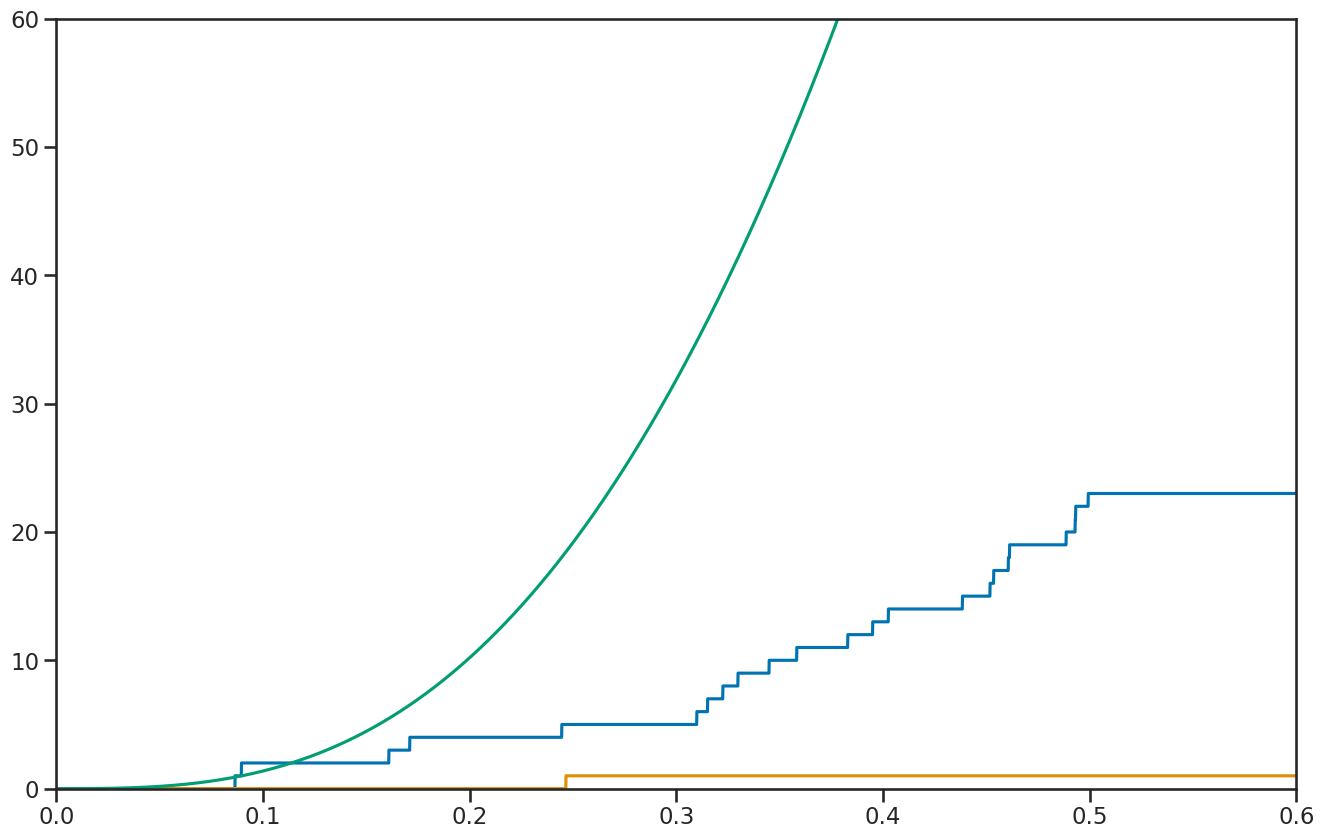

In [12]:
plt.plot(zgrid,Ngals_lessthanz_vmap(zgrid,1000))
plt.plot(zgrid,Nagns_lessthanz_vmap(zgrid,1000))
plt.plot(zgrid,N_expected_lessthanz_vmap(zgrid,H0Planck,Om0Planck,n0fid,gammafid))
plt.xlim(0,0.6)
plt.ylim(0,60)
plt.show()

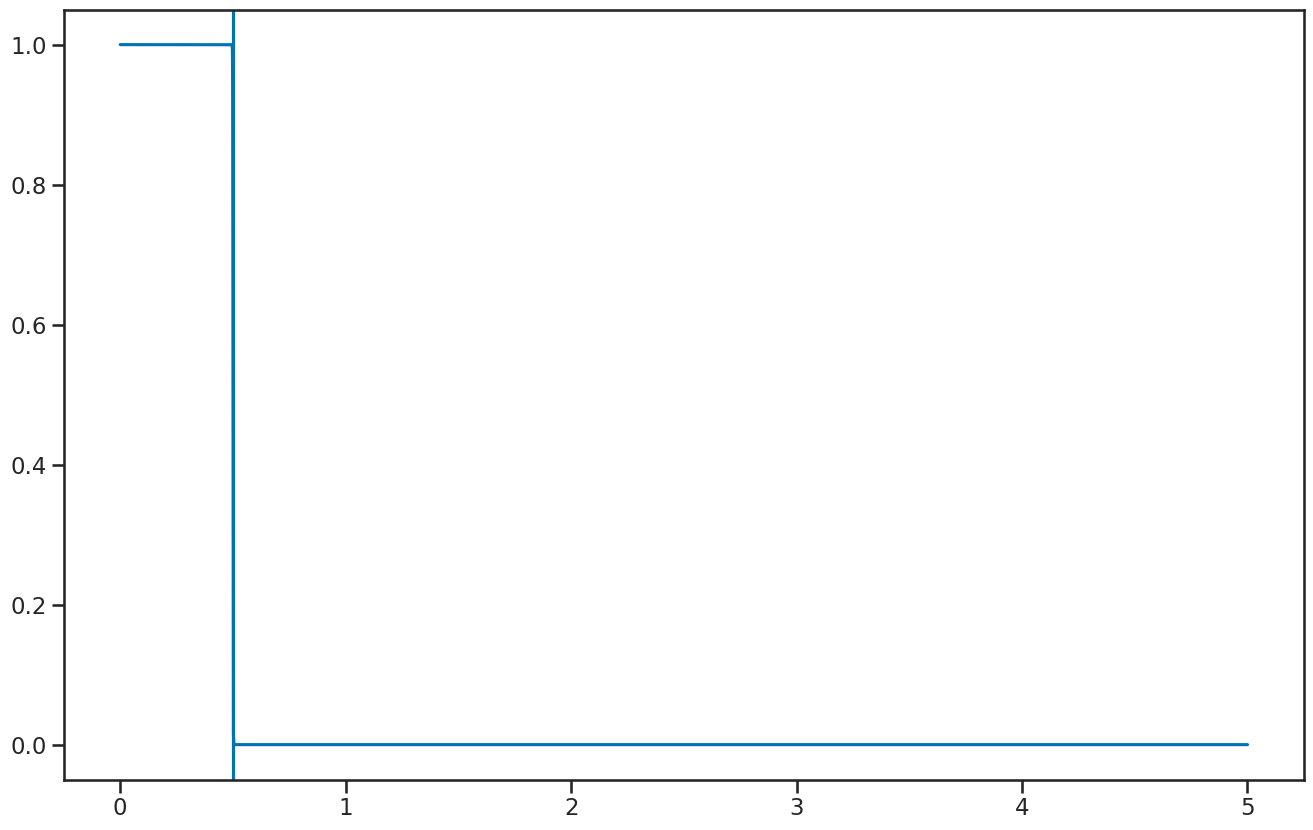

In [13]:
from jax.scipy.special import expit

z50 = 0.50
z1=1000
def Pcomplete0(z):
    return expit(-z1*(z/z50)+z1)
plt.plot(zgrid,Pcomplete0(zgrid))
plt.axvline(0.5)
plt.show()

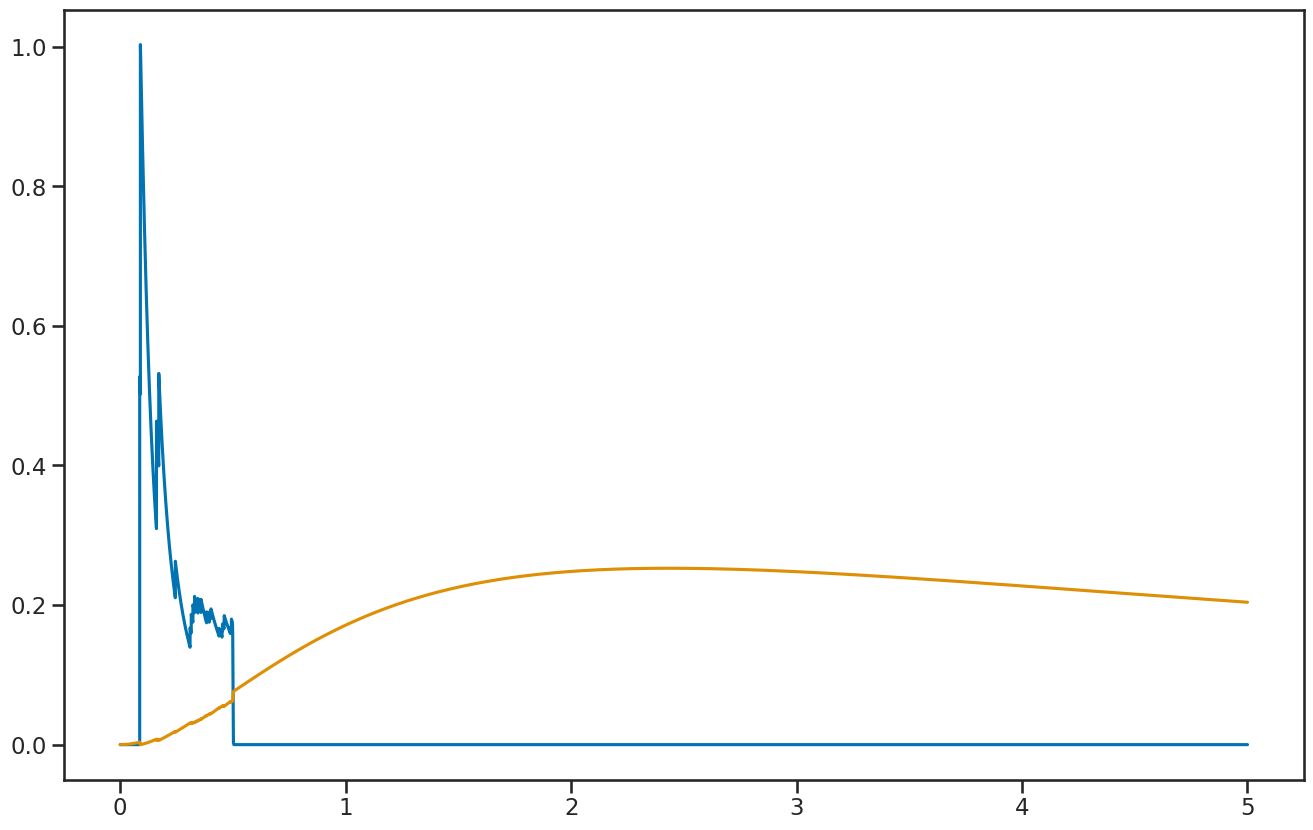

0.0030082842086563743


In [14]:
@jit
def completeness_fraction_gals(H0,Om0,n0,gamma,z,pix):
    Nexpected = 1+N_expected_lessthanz_vmap(zgrid,H0,Om0,n0,gamma)
    Ngals = Ngals_lessthanz_vmap(zgrid,pix)
    ratio = Ngals/Nexpected
    
    ratio *= Pcomplete0(zgrid)
    pvol = dV_of_z(zgrid, H0, Om0)*(1+zgrid)**(gamma-1)

    V = jnp.trapezoid(ratio*pvol,zgrid)
    Vmax = jnp.trapezoid(pvol,zgrid)
    
    pmiss = (1-ratio)*pvol
    pmiss_normed = pmiss/jnp.trapezoid(pmiss,zgrid)
    
    pmiss_z = jnp.interp(z,zgrid,pmiss_normed)

    return V/Vmax, pmiss_z, ratio

completeness_fraction_gals_vmap = jit(vmap(completeness_fraction_gals, in_axes=(None,None,None,None,0,0), out_axes=0))

f,pmiss,ratio=completeness_fraction_gals_vmap(H0Planck,Om0Planck,n0fid,gammafid,zgrid,1000*jnp.ones(len(zgrid),dtype=int))
plt.plot(zgrid,ratio[0])
plt.plot(zgrid,pmiss)
plt.show()
print(f[0])

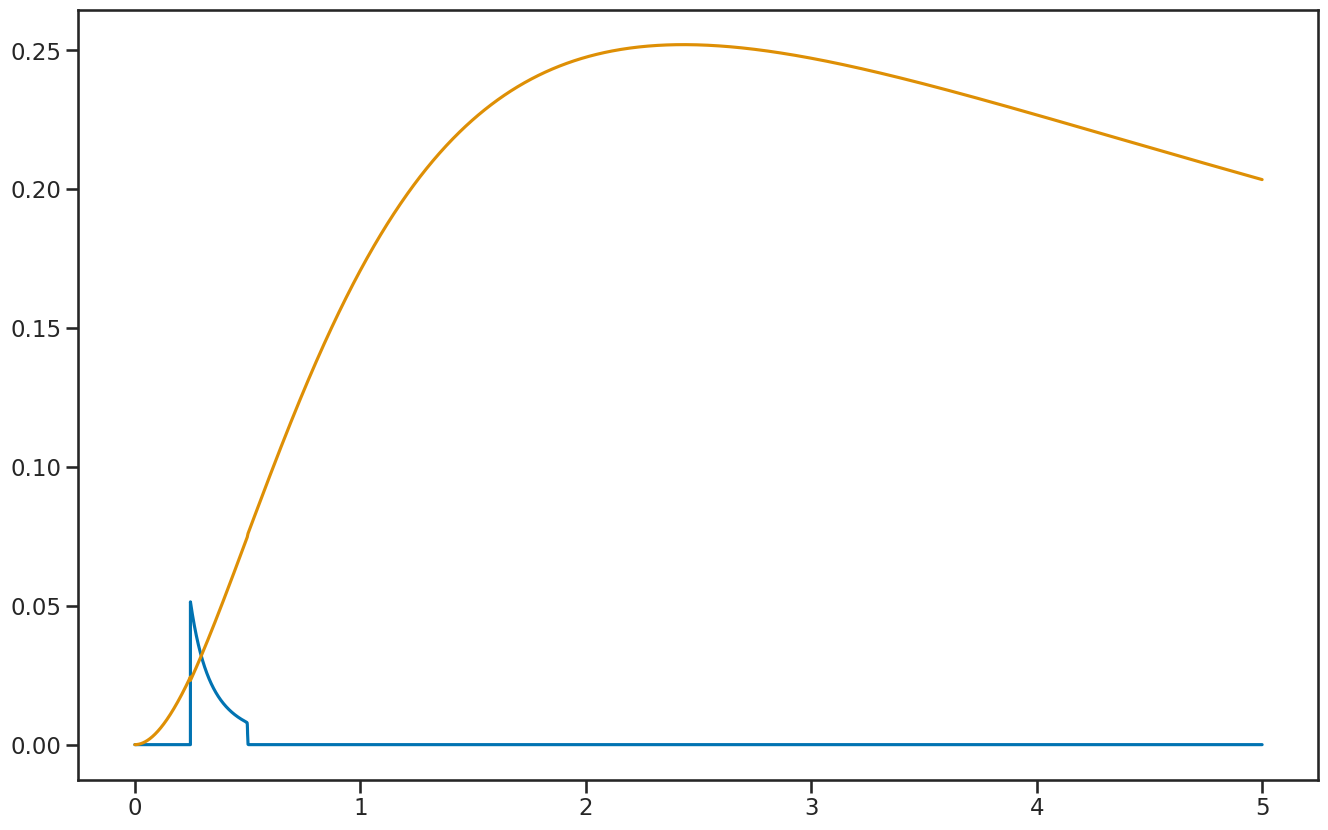

0.0002173808119570028


In [15]:
@jit
def completeness_fraction_agns(H0,Om0,n0,gamma,z,pix):
    Nexpected = 1+N_expected_lessthanz_vmap(zgrid,H0,Om0,n0,gamma)
    Nagns = Nagns_lessthanz_vmap(zgrid,pix)
    ratio = Nagns/Nexpected
    
    ratio *= Pcomplete0(zgrid)
    pvol = dV_of_z(zgrid, H0, Om0)*(1+zgrid)**(gamma-1)

    V = jnp.trapezoid(ratio*pvol,zgrid)
    Vmax = jnp.trapezoid(pvol,zgrid)
    
    pmiss = (1-ratio)*pvol
    pmiss_normed = pmiss/jnp.trapezoid(pmiss,zgrid)
    
    pmiss_z = jnp.interp(z,zgrid,pmiss_normed)

    return V/Vmax, pmiss_z, ratio

completeness_fraction_agns_vmap = jit(vmap(completeness_fraction_agns, in_axes=(None,None,None,None,0,0), out_axes=0))

f,pmiss,ratio=completeness_fraction_agns_vmap(H0Planck,Om0Planck,n0fid,gammafid,zgrid,1000*jnp.ones(len(zgrid),dtype=int))
plt.plot(zgrid,ratio[0])
plt.plot(zgrid,pmiss)
plt.show()
print(f[0])

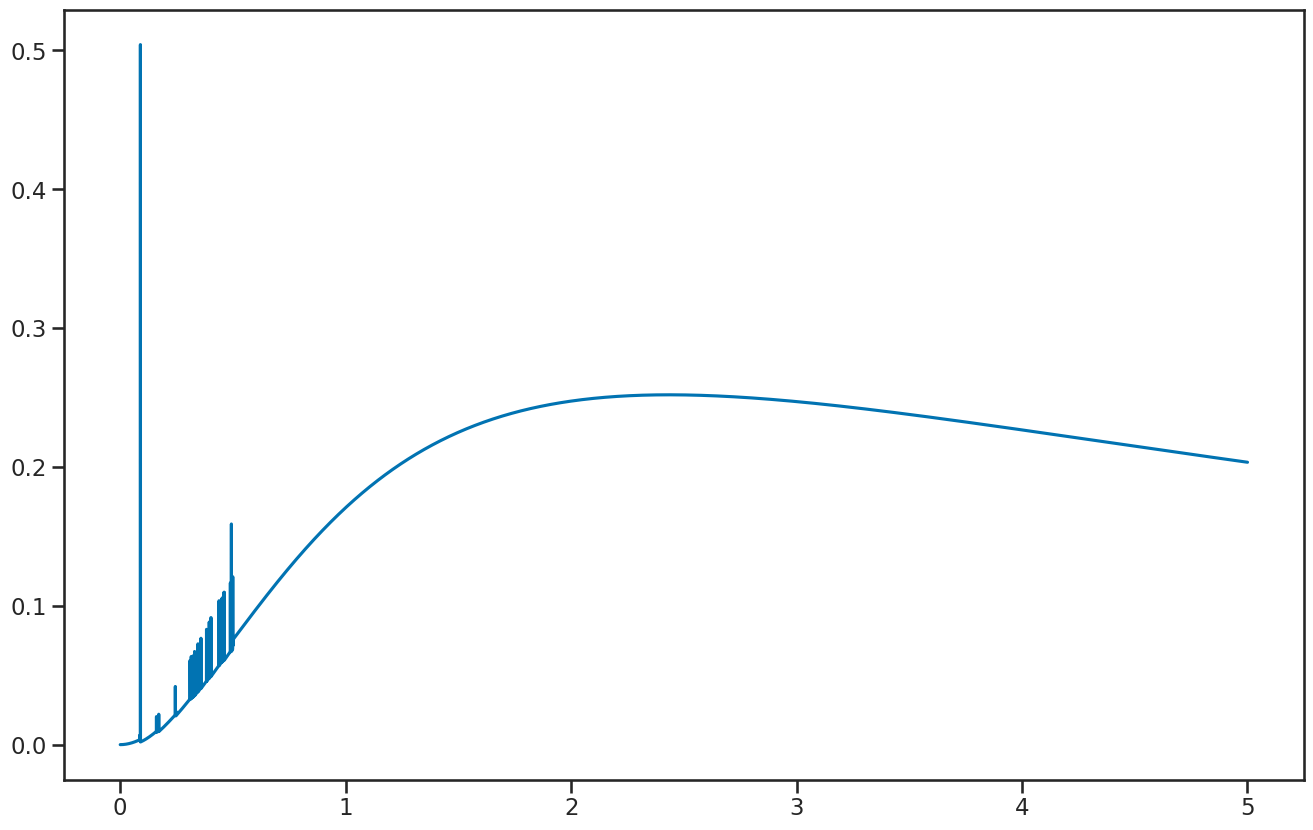

In [16]:
from jaxinterp2d import interp2d

@jit
def logpcatalog_gals(z, pix, Om0, gamma):
    zs = zgals[pix] 
    ddzs = dzgals[pix]
    wts = wgals[pix]*dV_of_z(zs,H0Planck,Om0)*(1+zs)**(gamma-1)
    ngals = len(zs)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs))

logpcatalog_gals_vmap = jit(vmap(logpcatalog_gals, in_axes=(0,0,None,None), out_axes=0))

@jit
def logpcatalog_agns(z, pix, Om0, gamma):
    zs = zagns[pix] 
    ddzs = dzagns[pix]
    wts = wagns[pix]*dV_of_z(zs,H0Planck,Om0)*(1+zs)**(gamma-1)
    nagns = len(zs)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs))

logpcatalog_agns_vmap = jit(vmap(logpcatalog_agns, in_axes=(0,0,None,None), out_axes=0))


@jit
def logPriorUniverse(z,pix,f,H0,Om0,n01,gamma1,n02,gamma2):
    f1, pmiss1, ratio1 = completeness_fraction_gals_vmap(H0,Om0,n01,gamma1,z,pix)
    f2, pmiss2, ratio2 = completeness_fraction_agns_vmap(H0,Om0,n02,gamma2,z,pix)

    logpmiss1 = jnp.nan_to_num(jnp.log(pmiss1), -jnp.inf)
    logpmiss2 = jnp.nan_to_num(jnp.log(pmiss2), -jnp.inf)

    logpcat_gals = jnp.nan_to_num(logpcatalog_gals_vmap(z, pix, Om0, gamma1), -jnp.inf)
    
    logpcat_agns = jnp.nan_to_num(logpcatalog_agns_vmap(z, pix, Om0, gamma2), -jnp.inf)
    
    logprob = jnp.log( f*(jnp.exp(jnp.log(f1) + logpcat_gals) + jnp.exp(jnp.log(1-f1) + logpmiss1)) 
                      +(1-f)*(jnp.exp(jnp.log(f2) + logpcat_agns) + jnp.exp(jnp.log(1-f2) + logpmiss2))
                     )

    return logprob

puniverse = jnp.exp(logPriorUniverse(zgrid,1000*jnp.ones(len(zgrid),dtype=int),0.5,H0Planck,Om0Planck,2e-4,1,2e-4,1))
plt.plot(zgrid,puniverse)
plt.show()


In [17]:
seed = np.random.randint(1000)
key = jax.random.PRNGKey(1000)

H0 = H0Planck
Om0 = Om0Planck
beta = 0

@jit
def darksiren_log_likelihood(f,log10n01,gamma1,log10n02,gamma2,mu,sigma):
    n01 = 10**log10n01
    n02 = 10**log10n02

    z = z_of_dL(dL, H0, Om0)
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)

    log_weights = log_p_pop_pl_pl(m1,m2,mu,sigma,beta)

    log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) - 2*jnp.log1p(z) + logPriorUniverse(z,samples_ind,f,H0,Om0Planck,n01,gamma1,n02,gamma2)

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll = jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll


In [18]:
darksiren_log_likelihood(f=0,log10n01=-4,gamma1=-3,mu=35,sigma=5,log10n02=-4,gamma2=-3)

Array(-17014.67584914, dtype=float64)

In [19]:
H0_lo = 20
H0_hi = 100

Om0_lo = Om0grid[0]
Om0_hi = Om0grid[-1] 

gamma_lo = -30.0
gamma_hi = 30.0

mu_lo = 20
mu_hi = 50

sigma_lo = 1
sigma_hi = 10

log10n0_lo = -8.0
log10n0_hi = 0.0

f_lo = 0.5
f_hi = 1

lower_bound = [f_lo, log10n0_lo, gamma_lo, log10n0_lo, gamma_lo, mu_lo, sigma_lo]
upper_bound = [f_hi, log10n0_hi, gamma_hi, log10n0_hi, gamma_hi, mu_hi, sigma_hi]

ndims = len(lower_bound)
nlive = 500

labels = [r'$f$',
          r'$\log_{10}n_{0,gal}$',r'$\gamma_{gal}$',
          r'$\log_{10}n_{0,agn}$',r'$\gamma_{agn}$',
          r'$\mu$',r'$\sigma$']

truths = [0.8,-4,-1,-4,-1,35,5]

def prior_transform(theta):
    transformed_params = [
        theta[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i] 
        for i in range(len(theta))
    ]
    
    return tuple(transformed_params)

def likelihood(coord):
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

def likelihood_emcee(coord):
    for i in range(len(coord)):
        if (coord[i]<lower_bound[i] or coord[i]>upper_bound[i]):
            return -np.inf
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

In [ ]:
import emcee

n_walkers = 64
p0 = np.random.uniform(lower_bound, upper_bound, size=(n_walkers, len(lower_bound)))
n_steps = 5000

sampler = emcee.EnsembleSampler(n_walkers, ndims, likelihood_emcee,
                                moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])#, pool=pool)
sampler.run_mcmc(p0, n_steps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 14%|█▍        | 693/5000 [2:55:01<9:08:05,  7.64s/it] 

In [23]:
shape = sampler.flatchain.shape[0]
print(shape)

dpostsamples_backup = sampler.flatchain[int(shape/2):,:]

shape = dpostsamples_backup.shape[0]
print(shape)
choose = np.random.randint(0,shape,10000)
choose

320000
160000


array([ 48484,  29689,  71528, ..., 157926, 109747,  59111])

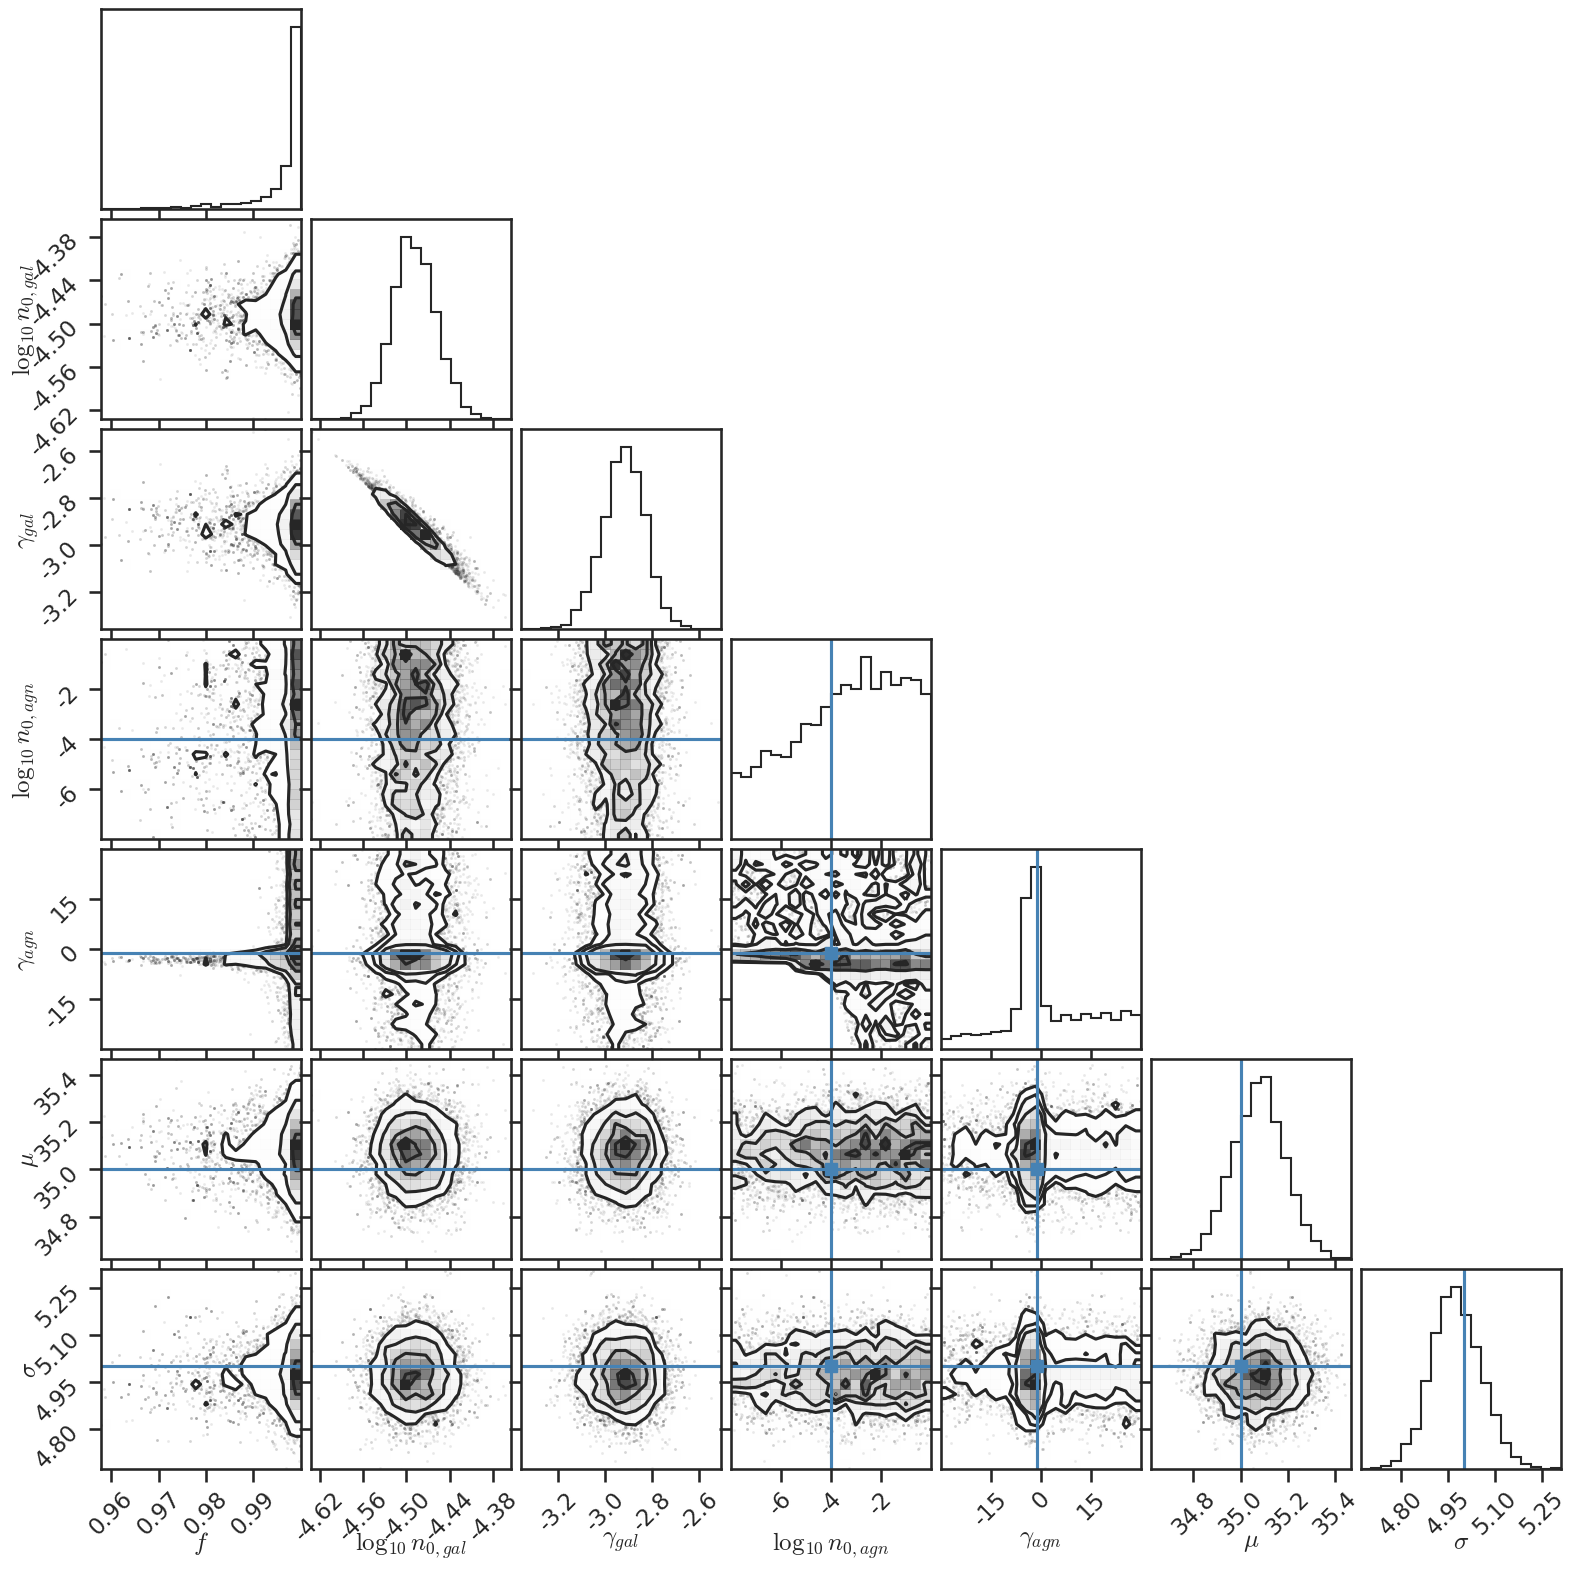

In [24]:
import corner

dpostsamples = dpostsamples_backup[choose]

fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True},truths=truths)#, range=ranges)
#plt.savefig('corner.pdf')
plt.show()